# Задание 3: расположение меток/подписей (label placement) 

## Постановка задачи

**Входные данные:**

Файл, в каждой строчке которого закодировано положение точки, размер метки и набор возможных положений метки. Закодировано это следующим образом, POINT_X,POINT_Y\tLABEL_SIZE_X,LABEL_SIZE_Y\tFIRST_VARIANT_X,FIRST_VARIANT_Y SECOND_VARIANT_X,SECOND_VARIANT_Y ...

Количество вариантов для каждой точки не ограничено.

Необходимо отрисовать все точки с метками без пересечения этих меток.

## Метод решения

Сведем задачу к поиску максимальной клики в графе. Для этого закодируем для каждой точки и каждого варианта расположения метки вершину в графе с лейблом `{point_number}__{variant_number}`. Ребра между вершинами будим проводить только если эти вершины соответсвуют разным точкам и метки для данных вариантов не пересекаются.

После того как граф построен нам нужно найти в нем максимальный полносвязный подграф. Если размер этого подграфа равен количеству точек, значит расположение без пересечений возможно, иначе нет.

Для ускорения процедуры нахождения максимального подграфа можно из графа выкинуть все вершины соответсвующие точкам с вариантом метки таким, что она ни с кем не пересекается. Это очень часто позволяет ускорить процесс нахождения максимальной клики.

In [55]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from tqdm.auto import tqdm
from networkx.algorithms.clique import find_cliques as maximal_cliques
from networkx.algorithms.clique import find_cliques_recursive 
import networkx as nx
import time
import datetime
from itertools import combinations

In [118]:
def read_file(file_name):
    points = []
    with open(file_name, "r") as f:
        for line in f.read().split("\n"):
            cur_point = {}
            pos, size, possible = line.split("\t")
            cur_point["x"] = int(pos.split(",")[0])
            cur_point["y"] = int(pos.split(",")[1])
            cur_point["size_x"] = int(size.split(",")[0])
            cur_point["size_y"] = int(size.split(",")[1])
            cur_point["variants"] = []
            for version in possible.split(" "):
                cur_point["variants"].append([int(version.split(",")[0]), int(version.split(",")[1])])
            points.append(cur_point)
    return points

def point_in_rectangular(x_min, x_max, y_min, y_max, x, y):
    return (x < x_max) and (x > x_min) and (y < y_max) and (y > y_min)

def rectangular_have_intersection_with_rectangular(x_min, x_max, y_min, y_max, 
                                                   x2_min, x2_max, y2_min, y2_max):
    
    if (x_max<x2_min or x2_max<x_min or y_max<y2_min or y2_max<y_min):
        return False
    else:
        return True
    

def build_graph(points):
    n = len(points)

    G = nx.Graph()
    all_possible = []
    banned_variants = []
    
    for i in tqdm(range(n)):
        for ver_i, version in enumerate(points[i]["variants"]): 
            x_min = points[i]["x"] - version[0]
            x_max = x_min + points[i]["size_x"]
            
            y_min = points[i]["y"] - version[1]
            y_max = y_min + points[i]["size_y"]
            G.add_node(str(i) + "__" + str(ver_i))
            
            for j in range(i + 1, n):
                
                if point_in_rectangular(x_min, x_max, y_min, y_max, points[j]["x"], points[j]["y"]):
                    banned_variants.append(str(i) + "__" + str(ver_i))
                    for ver_j in range(len(points[j]["variants"])):
                        banned_variants.append(str(j) + "__" + str(ver_j)) 
                else:
                    for ver_j, version_second in enumerate(points[j]["variants"]):
                        G.add_node(str(j) + "__" + str(ver_j))
                        
                        j_x_min = points[j]["x"] - version_second[0]
                        j_x_max = j_x_min + points[j]["size_x"]

                        j_y_min = points[j]["y"] - version_second[1]
                        j_y_max = j_y_min + points[j]["size_y"]
                        
                        if rectangular_have_intersection_with_rectangular(x_min, x_max, y_min, y_max, 
                                                   j_x_min, j_x_max, j_y_min, j_y_max):
                        
                            banned_variants.append(str(i) + "__" + str(ver_i))
                            banned_variants.append(str(j) + "__" + str(ver_j))
                        else:
                            G.add_edge(str(i) + "__" + str(ver_i), str(j) + "__" + str(ver_j))
            if (str(i) + "__" + str(ver_i)) not in banned_variants:
                all_possible.append(str(i) + "__" + str(ver_i))
                for k in range(len(points[i]["variants"])):
                    if (str(i) + "__" + str(k)) in G.nodes:
                        G.remove_node(str(i) + "__" + str(k))
                break
                            
    return G, all_possible

def plot_points(points, versions):
    
    dots_x = []
    dots_y = []
    
    for point in points:
        dots_x.append(point["x"])
        dots_y.append(point["y"])
    
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.plot(dots_x, dots_y, "o")
    
    for iterator, (point, version) in enumerate(zip(points, versions)):
        
        rect = patches.Rectangle((point["x"] - point["variants"][version][0], 
                                  point["y"] - point["variants"][version][1]), 
                                 point["size_x"], point["size_y"], 
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')
        ax.add_patch(rect)
    plt.show()

def find_version(points):
    G, all_possible = build_graph(points)
    
    result = []
    max_clique_size = 0
    
    graph_degree_dict = defaultdict(int)

    for key, value in G.degree:
        i = int(key.split("__")[0])
        graph_degree_dict[i] += value

    for key, val in graph_degree_dict.items():
        if val == 0:
            print("It's impossible!")
            return None

    for item in maximal_cliques(G):
        if len(item) > max_clique_size:
            max_clique_size = len(item)
            result = item
            if len(points) == len(item) + len(all_possible):
                break
    
    if len(points) != len(result) + len(all_possible):
        print("It's impossible!")
        return None
    
    final_result = result + all_possible
    
    final_version = [0 for _ in range(len(points))]

    for item in final_result:
        i, ver = item.split("__")

        final_version[int(i)] = int(ver)

    return final_version
    

# Example

In [119]:
points = [
    {'x': 185,
     'y': 145,
     'size_x': 28,
     'size_y': 16,
     'variants': [[0, 0], [28, 0]]},
    {'x': 130,
     'y': 49,
     'size_x': 45,
     'size_y': 15,
     'variants': [[0, 0], [45, 0]]},
    {'x': 116,
     'y': 109,
     'size_x': 48,
     'size_y': 17,
     'variants': [[24, 17], [48, 0]]},
    {'x': 36,
     'y': 178,
     'size_x': 27,
     'size_y': 46,
     'variants': [[0, 0], [27, 46]]},
]

In [120]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 1.600*10^1 вариантов


In [121]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:00:00.018379


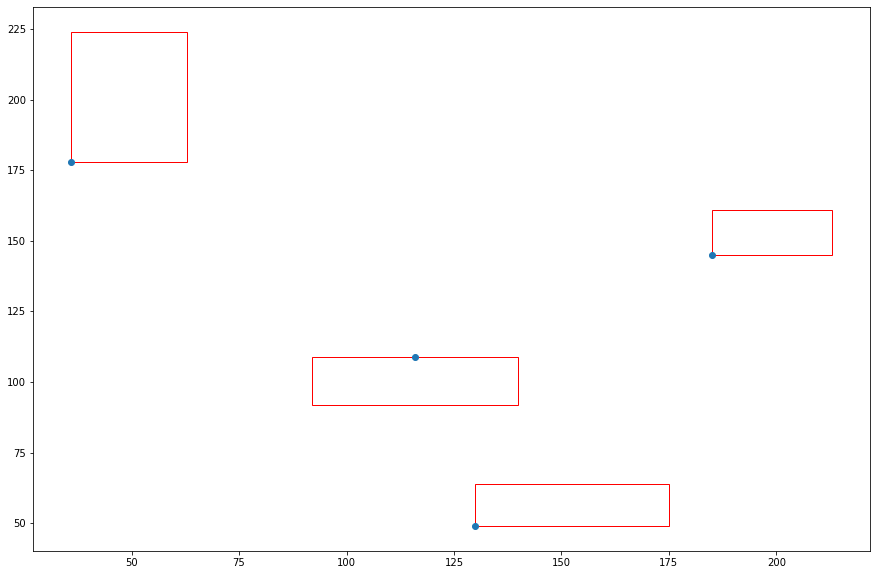

In [122]:
plot_points(points, version)

# Hard1

In [97]:
points = read_file("hard1.txt") ## Download points from file

In [98]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 1.351*10^16 вариантов


In [45]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:00:10.891801


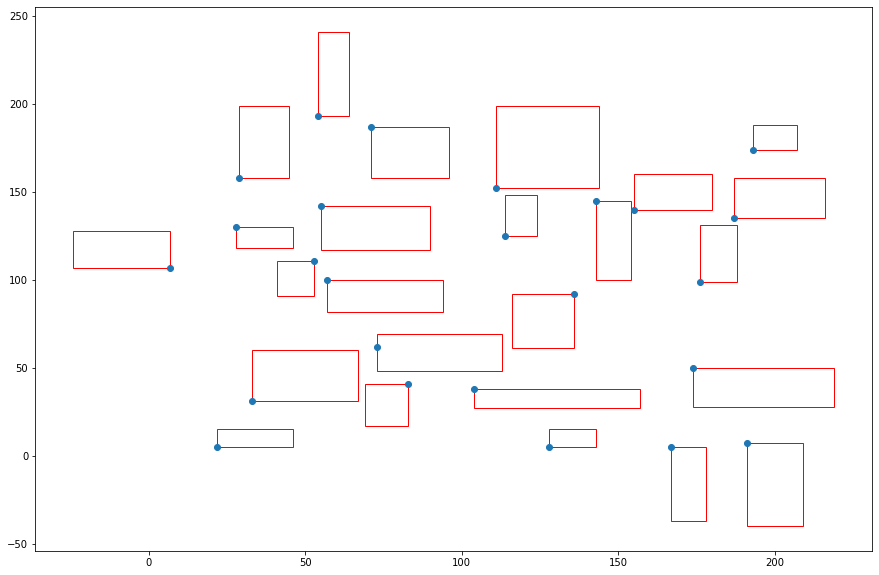

In [46]:
plot_points(points, version)

# Hard2

In [99]:
points = read_file("hard2.txt")

In [100]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 2.850*10^15 вариантов


In [36]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:00:42.377500


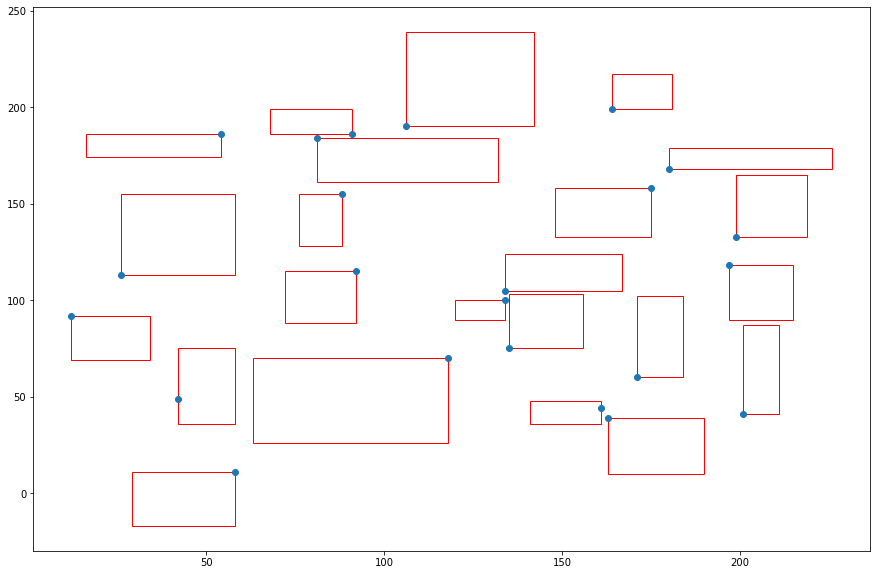

In [49]:
plot_points(points, version)

# Hard3

In [101]:
points = read_file("hard3.txt")

In [102]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 2.626*10^19 вариантов


In [39]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:01:20.064511


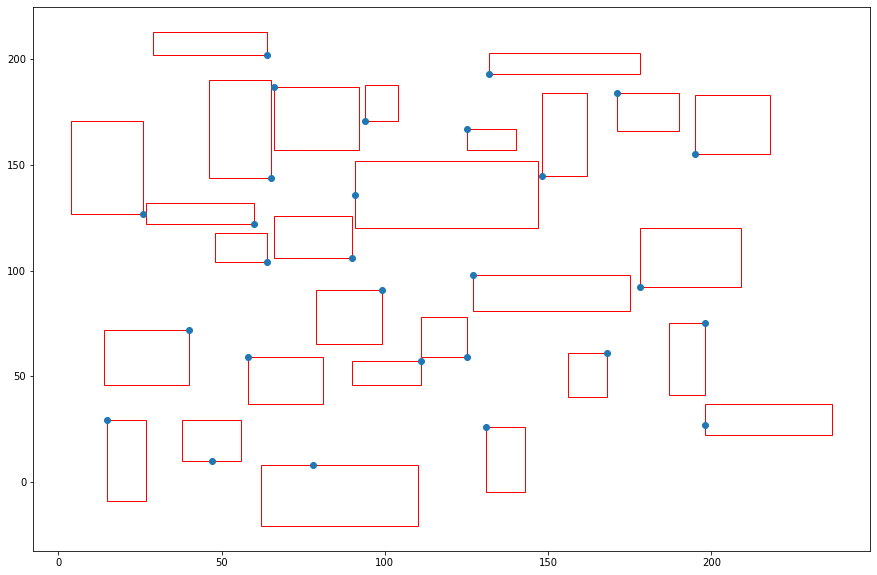

In [40]:
plot_points(points, version)

# Bin1

In [103]:
points = read_file("bin1.txt")

In [104]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 1.678*10^7 вариантов


In [92]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:00:00.022786


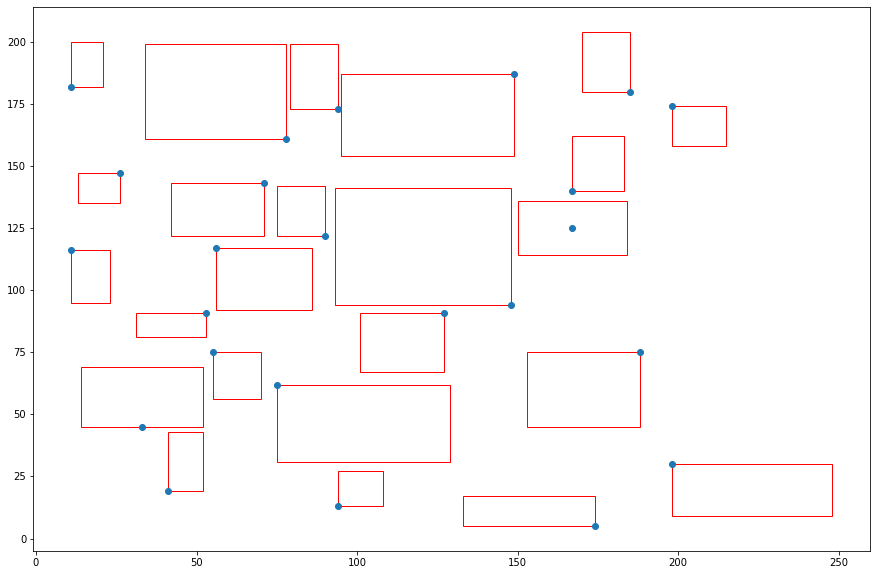

In [93]:
plot_points(points, version)

# Bin2

In [105]:
points = read_file("bin2.txt")

In [106]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 8.389*10^6 вариантов


In [65]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:00:00.033887


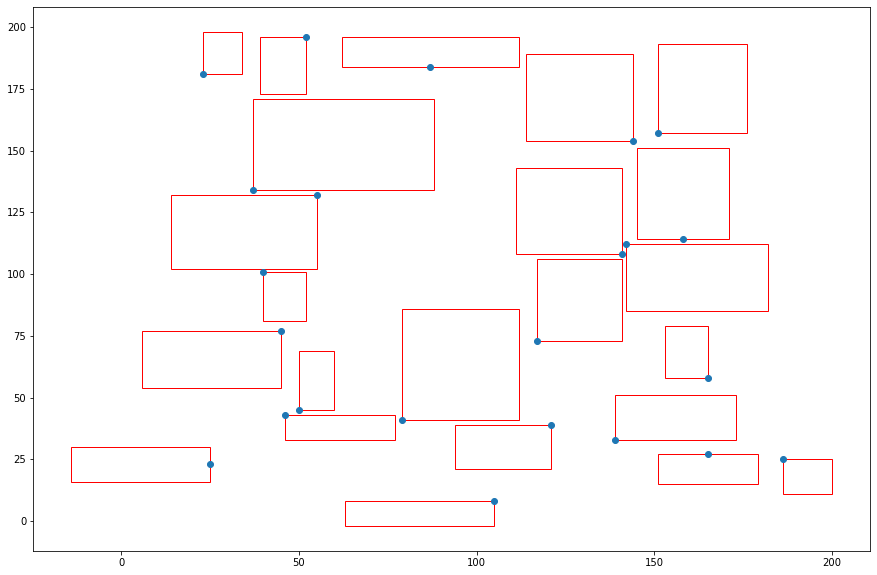

In [66]:
plot_points(points, version)

# Bin3

In [107]:
points = read_file("bin3.txt")

In [108]:
all_variants = 1
for point in points:
    all_variants *= len(point["variants"])

degree = 0
while all_variants > 10:
    all_variants /= 10
    degree += 1
print("Всего {:.3f}*10^{} вариантов".format(all_variants, degree))

Всего 2.097*10^6 вариантов


In [69]:
start_time = time.perf_counter()
version = find_version(points)
print("Running time: " + str(datetime.timedelta(seconds=time.perf_counter() - start_time)))


Running time: 0:00:00.020801


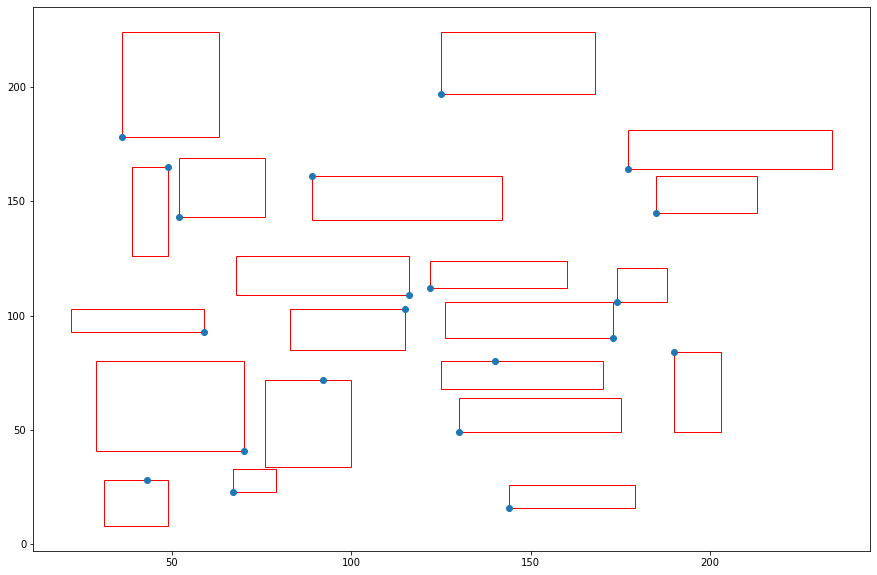

In [70]:
plot_points(points, version)